In [1]:
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist
import hist.plot

sys.path.append("../../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v35'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}

In [3]:
def getHist(beamEnergy, datatype, cleaned):
    return (histStore.get(HistogramId("Clus3DAnglePCAToImpact" + ("_Cleaned" if cleaned else ""), clueParams, datatype))
        .getHistogram(HistogramKind.COUNT)[{
            "beamEnergy":hist.loc(beamEnergy),
            "mainOrAllTracksters":hist.loc("mainTrackster"),
        }]
    .project("clus3D_angle_pca_impact_filterLayerSpan_cleaned" if cleaned else "clus3D_angle_pca_impact_filterLayerSpan")
    )

In [4]:
getHist(20, "data", False)#.axes[0].centers

Hist(Regular(1000, 0, 1.5708, name='clus3D_angle_pca_impact_filterLayerSpan', label='Angle between shower direction estimated from PCA and extrapolated track from DWC'), storage=Double()) # Sum: 19798.0

In [5]:
def mpv(h:hist.Hist):
    return h.axes[0].centers[np.argmax(h.counts())]

In [6]:
def countHistogramToWeightHistogram(h:hist.Hist):
    """ Transform a count boost.histogram (ie Double storage type) to a Weight storage histogram, with weights=1 """
    w_h = hist.Hist(*h.axes, storage=hist.storage.Weight())
    w_h.view(flow=True).value, w_h.view(flow=True).variance = h.view(flow=True), h.view(flow=True)
    return w_h

def addLumiLegend(main_ax, datatypes, beamEnergies):
    if "data" in datatypes:
        hep.cms.text("Preliminary", ax=main_ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=main_ax)
    if isinstance(beamEnergies, list):
        hep.cms.lumitext(f"$e^+$ test beam", ax=main_ax)
    else:
        hep.cms.lumitext(f"$e^+$ {str(beamEnergies)} GeV", ax=main_ax)
    main_ax.legend()

def plot(beamEnergies, datatypes, cleaned, log=False):
    if isinstance(cleaned, list):
        hists = [getHist(beamEnergies, datatypes, cleaned_i) for cleaned_i in cleaned]
        cleanedMap = {True : "Cleaned", False:"No LC selection"}
        labels = [cleanedMap[i] for i in cleaned]
    elif isinstance(datatypes, list):
        hists = [getHist(beamEnergies, datatype, cleaned) for datatype in datatypes]
        for i in range(len(datatypes)):
            if i == 0:
                count_data = hists[0].sum(flow=True)
            else:
                hists[i] = countHistogramToWeightHistogram(hists[i]) * (count_data / hists[i].sum(flow=True))
        labels = [datatypeToLegendMap[datatype] for datatype in datatypes]
    elif isinstance(beamEnergies, list):
        hists = [getHist(beamEnergy, datatypes, cleaned) for beamEnergy in beamEnergies]
        labels = [f"{beamEnergy} GeV" for beamEnergy in beamEnergies]
    else:
        hists = [getHist(beamEnergies, datatypes, cleaned)]
        labels = None

    for i, (h, label) in enumerate(zip(hists, labels)):
        labels[i] = label + f" - MPV={mpv(h):.2g}"

    fig, ax = plt.subplots()

    hep.histplot(hists, yerr=False, label=labels)

    if log:
        ax.set_yscale("log")
        ax.set_xlim(0, 0.25)
    else:
        ax.set_xlim(0, 0.1)
    
    ax.set_xlabel("Angle PCA axis / DWC track (radians)")
    ax.set_ylabel("Event count")

    addLumiLegend(ax, datatypes, beamEnergies)

    

## Compare data/sim

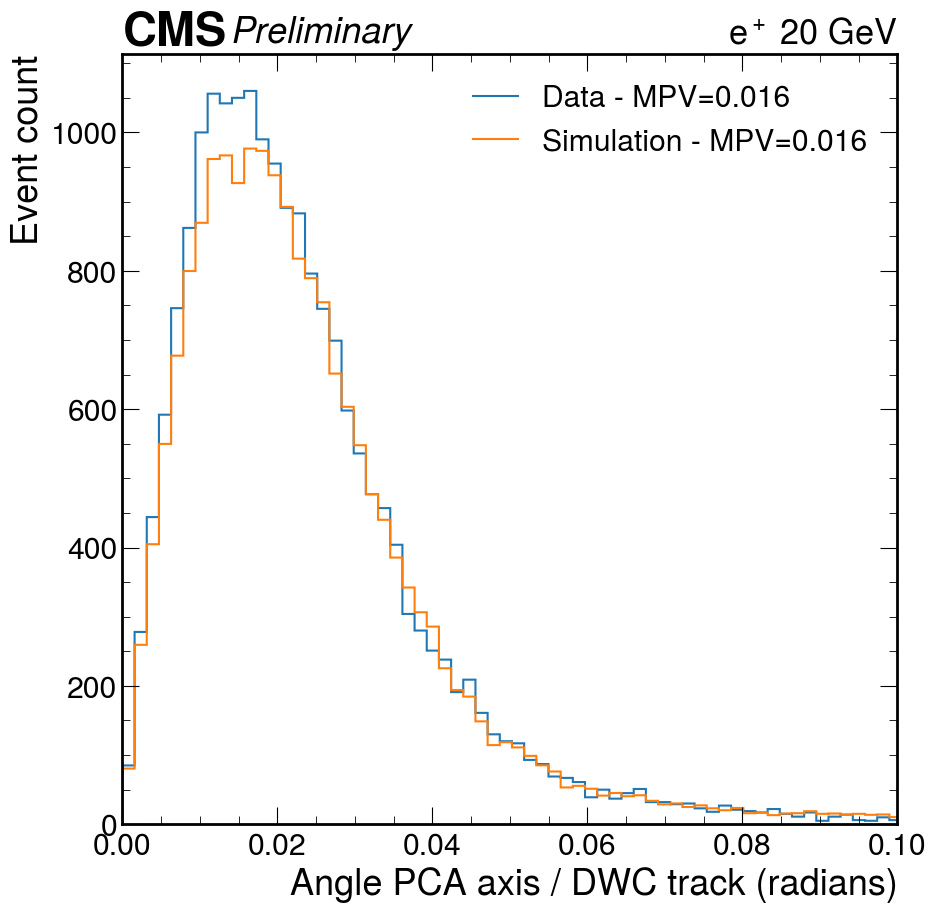

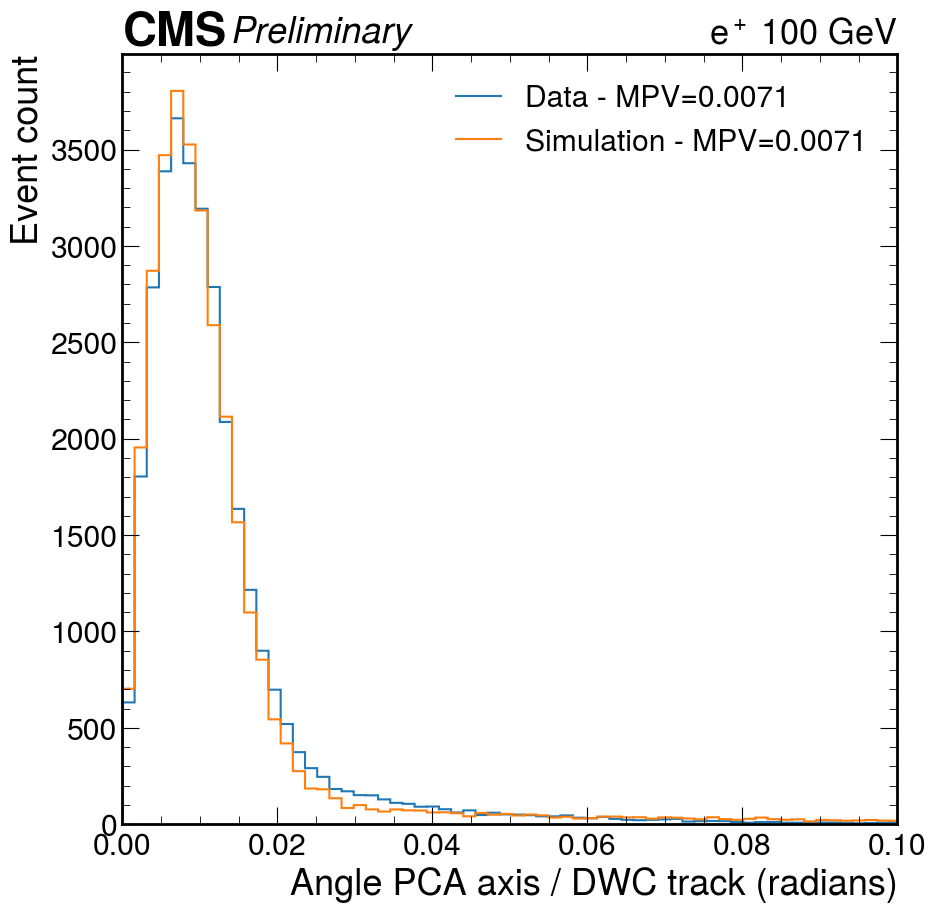

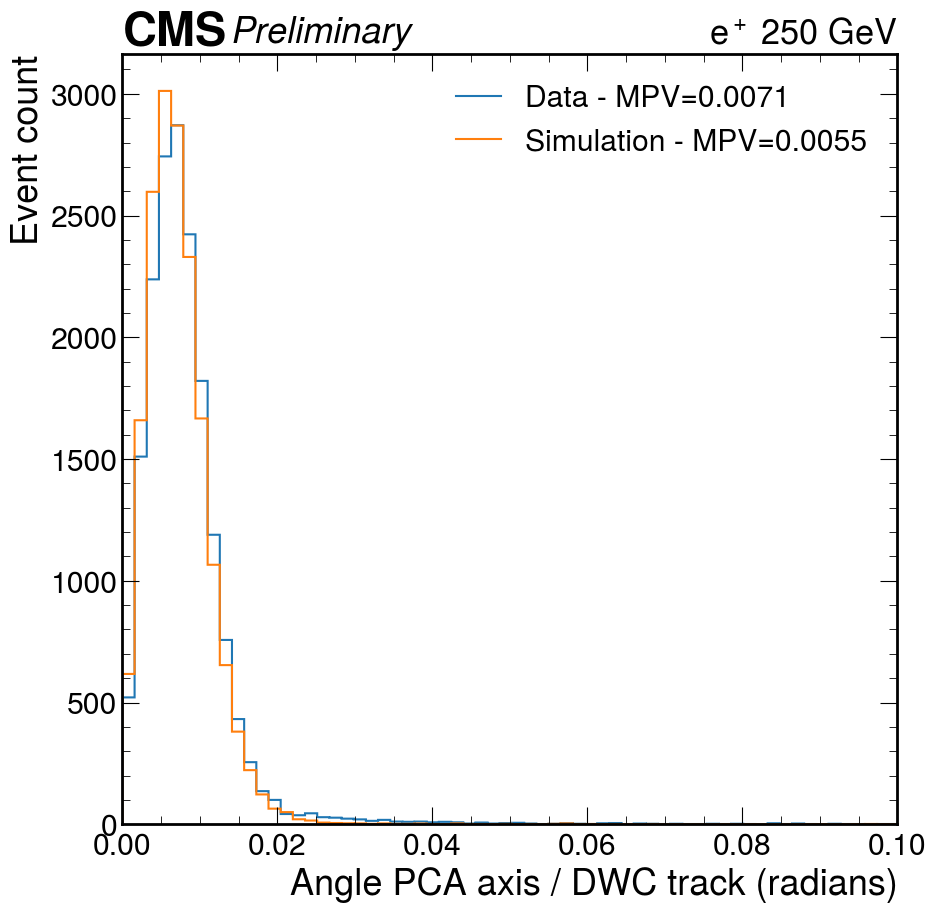

In [7]:
plot(20, ["data", "sim_proton_v46_patchMIP"], False)
plot(100, ["data", "sim_proton_v46_patchMIP"], False)
plot(250, ["data", "sim_proton_v46_patchMIP"], False)

## Compare cleaned/not cleaned

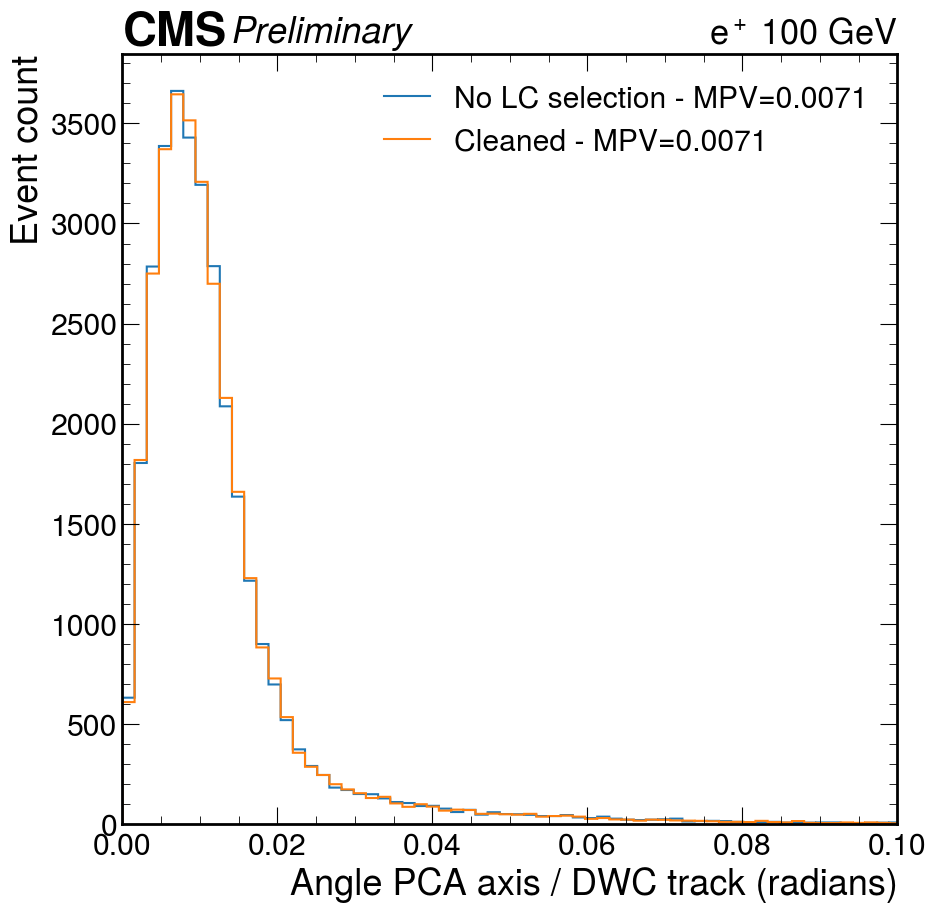

In [8]:
plot(100, "data", [False, True])

## Compare beam energies

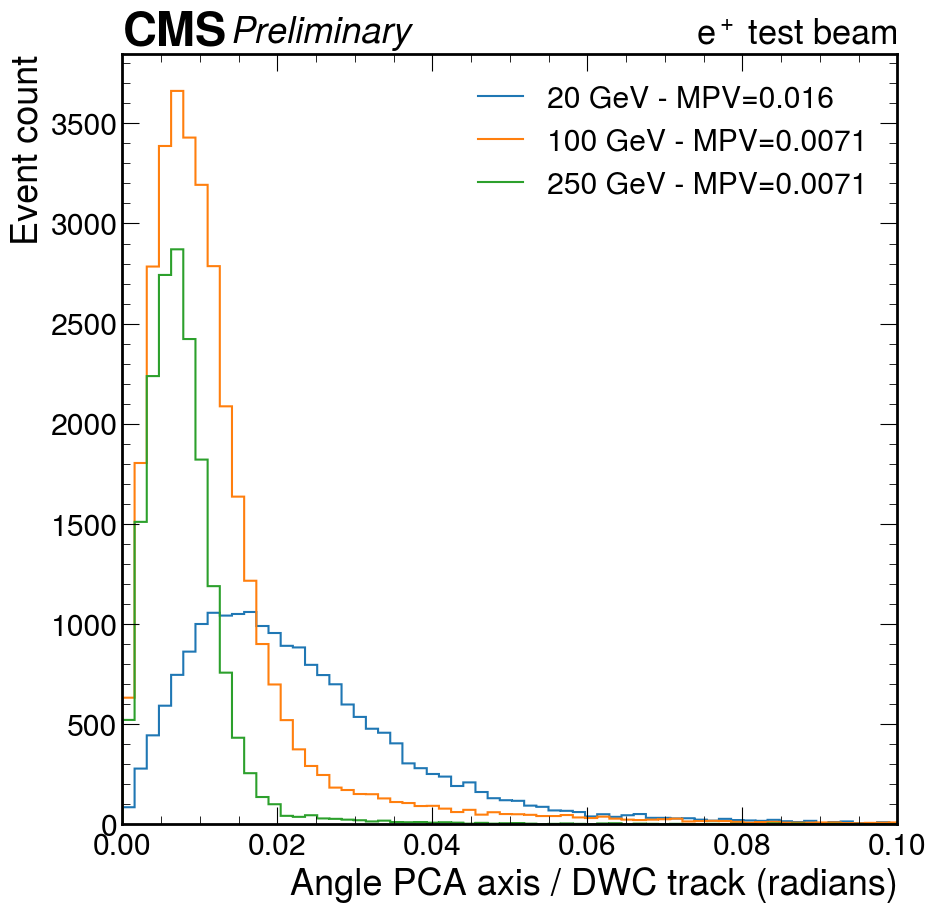

In [9]:
plot([20, 100, 250], "data", False)